## Description

* Train linear regression and gradient boosting regressor models to predict property prices based on the following set of features
    * Number of bedrooms
    * Number of bathrooms 
    * Building age
    * Building total area in square feet
    * Number of floors
    * Location (latitude and longitude)
    * Number of parks within 1 mile from the property
    * Number of coffee shops within 1 mile of the property
    * Property gun violence score

In [1083]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error


In [1084]:
def scatter_vs_price(df, col):
    plt.scatter(df[col], df.PRICE_1)
    plt.title("PRICE_1 v.s {}".format(col))
    
def six_sigma_filter(df, column):
    sigma = df[column].std()
    mu = df[column].mean()
    three_sigma = [mu-(3*sigma), mu+(3*sigma)]
    print("Column:{}, Mean:{}, Sigma:{}, 6 sigma_range: {}:{}".format(column,mu.round(3),
                                                                       sigma.round(3),
                                                                       three_sigma[0].round(2),
                                                                       three_sigma[1].round(2)))
    
    # filter
    df_to_keep = df[(df[column] > three_sigma[0]) & (df[column] < three_sigma[1])]
    
    # prints
    num_rows_dropped = df.shape[0] - df_to_keep.shape[0]
    print("Number of rows dropped: " + str(num_rows_dropped))
    
    return df_to_keep

def min_max_scale(df, cols):
    mm_scaler = MinMaxScaler() 
    scaled_array = mm_scaler.fit_transform(df[cols])
    return pd.DataFrame(scaled_array, columns=cols)

def corr(df):
    corr = df.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
    plt.show()

In [1085]:
facilities_path = '../Data/arcgis/neighborhood_facilities_2019_1_miles.csv'
gun_violence_path = '../Data/arcgis/property_point_view_2019_gun_viol_totals_1.0_miles.csv'
prop_path = '../Data/arcgis/property_point_view_2019.csv'

In [1086]:
gv_df = pd.read_csv(gun_violence_path)
gv_df.head()

property_index  incident_count  injured_count  killed_count
0               0              72             71            27
1               1              64             67            24
2               2              65             68            24
3               3              68             67            27
4               4              68             69            26

In [1087]:
# Compute score

incidents_weight = 1.0
injured_weight = 1.5
killed_weight = 2.0
n_years = 5


gv_df['gv_score'] = (killed_weight*gv_df['killed_count'] + injured_weight*gv_df['injured_count'] +  incidents_weight*gv_df['incident_count'])/n_years
gv_df.head()

property_index  incident_count  injured_count  killed_count  gv_score
0               0              72             71            27      46.5
1               1              64             67            24      42.5
2               2              65             68            24      43.0
3               3              68             67            27      44.5
4               4              68             69            26      44.7

In [1088]:
gv_df.describe()

property_index  incident_count  injured_count  killed_count  \
count    16399.000000    16399.000000   16399.000000  16399.000000   
mean      8199.000000       11.587658       8.206415      4.422038   
std       4734.127868       16.245077      14.504846      6.608888   
min          0.000000        0.000000       0.000000      0.000000   
25%       4099.500000        2.000000       1.000000      1.000000   
50%       8199.000000        5.000000       3.000000      2.000000   
75%      12298.500000       14.000000       9.000000      5.000000   
max      16398.000000      113.000000     143.000000     55.000000   

           gv_score  
count  16399.000000  
mean       6.548271  
std        9.987854  
min        0.000000  
25%        1.100000  
50%        3.000000  
75%        7.400000  
max       85.100000

In [1089]:
facilities_df = pd.read_csv(facilities_path)
facilities_df.head()

grocery_count  restaurant_count  hospitals_count  coffee_count  bars_count  \
0              5                18                0             0           0   
1              2                12                0             0           0   
2              2                12                0             0           0   
3              2                 7                0             0           0   
4              4                17                0             0           0   

   gas_count  parks_count  edu_count  
0          8            9          4  
1          7            6          4  
2          8            6          4  
3          3            6          6  
4          8            8          4

In [1090]:
prop_df = pd.read_csv(prop_path)

# replace condo flag: N--> 0 , Y --> 1
prop_df.replace({'CONDO_FLAG' : {'Y': 1, 'N':0}}, inplace=True)
prop_df['AGE'] = 2019 - prop_df['YEAR_BUILT'] 
prop_df['OUTDOORS_AREA'] = prop_df['BUILDING_ACTUAL_AREA'] - prop_df['BUILDING_HEATED_AREA'] 

print(prop_df.columns)
prop_df.head()

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA'],
      dtype='object')


X          Y         CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0 -80.201382  25.843438  NORTH MIAMI  33150.0           0            2.0   
1 -80.204222  25.845806        MIAMI  33150.0           0            3.0   
2 -80.203909  25.845515        MIAMI  33150.0           0            2.0   
3 -80.206837  25.846260        MIAMI  33150.0           0            4.0   
4 -80.201535  25.844182  MIAMI BEACH  33150.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  UNIT_COUNT  ...  \
0             1.0                  0.0          1.0         1.0  ...   
1             1.0                  0.0          1.0         1.0  ...   
2             1.0                  0.0          1.0         1.0  ...   
3             4.0                  0.0          1.0         2.0  ...   
4             2.0                  0.0          1.0         1.0  ...   

   BUILDING_HEATED_AREA  LOT_SIZE  YEAR_BUILT  ASSESSMENT_YEAR_CUR  \
0                1237.0    7875.0      1924.0               2020.0   
1                1693.0    7390.5      1936.0               2020.0   
2                 728.0    4450.0      1936.0               2020.0   
3                1750.0    5294.0      1998.0               2020.0   
4                1517.0   20100.0      1925.0               2020.0   

   ASSESSED_VAL_CUR   PRICE_1             DATEOFSALE_UTC SQRD_FOOT_PRICE  \
0          166702.0  168000.0  2019-07-08 04:00:00+00:00      135.812449   
1          169942.0  159000.0  2019-07-17 04:00:00+00:00       93.916125   
2           70838.0  129900.0  2019-01-31 05:00:00+00:00      127.352941   
3          155062.0  240000.0  2019-03-12 04:00:00+00:00      125.130344   
4          188046.0  335000.0  2019-06-03 04:00:00+00:00      220.830587   

    AGE  OUTDOORS_AREA  
0  95.0            0.0  
1  83.0            0.0  
2  83.0          292.0  
3  21.0          168.0  
4  94.0            0.0  

[5 rows x 21 columns]

In [1091]:
prop_df.describe()

X             Y           ZIP    CONDO_FLAG  BEDROOM_COUNT  \
count  16399.000000  16399.000000  16399.000000  16399.000000   16399.000000   
mean     -80.300882     25.758936  33128.900116      0.349777       2.682237   
std        0.103181      0.141156     59.874734      0.476914       1.093315   
min      -80.557561     25.399216  33010.000000      0.000000       0.000000   
25%      -80.385921     25.670566  33125.000000      0.000000       2.000000   
50%      -80.314025     25.771513  33149.000000      0.000000       3.000000   
75%      -80.207915     25.875636  33176.000000      1.000000       3.000000   
max      -80.119450     25.974065  33196.000000      1.000000       9.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT   FLOOR_COUNT    UNIT_COUNT  \
count    16399.000000         16399.000000  16399.000000  16399.000000   
mean         1.830356             0.143728      0.816208      1.033600   
std          0.687652             0.354112      0.707756      0.180202   
min          0.000000             0.000000      0.000000      1.000000   
25%          1.000000             0.000000      0.000000      1.000000   
50%          2.000000             0.000000      1.000000      1.000000   
75%          2.000000             0.000000      1.000000      1.000000   
max          6.000000             2.000000     11.000000      2.000000   

       BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA       LOT_SIZE  \
count          16399.000000          16399.000000   16399.000000   
mean            1648.555766           1471.793280    5009.168000   
std              737.329084            587.530409    8410.812035   
min              500.000000            480.000000       0.000000   
25%             1089.000000           1046.000000       0.000000   
50%             1516.000000           1380.000000    4700.000000   
75%             2065.000000           1785.000000    7500.000000   
max             5923.000000           5046.000000  217800.000000   

         YEAR_BUILT  ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR        PRICE_1  \
count  16399.000000              16399.0      1.639900e+04   16399.000000   
mean    1979.185438               2020.0      2.094718e+05  294694.159888   
std       22.308426                  0.0      1.081768e+05  115541.317944   
min     1901.000000               2020.0      1.272200e+04  100000.000000   
25%     1960.000000               2020.0      1.313885e+05  204000.000000   
50%     1979.000000               2020.0      1.940000e+05  283500.000000   
75%     2000.000000               2020.0      2.670000e+05  370000.000000   
max     2019.000000               2020.0      3.182000e+06  600000.000000   

       SQRD_FOOT_PRICE           AGE  OUTDOORS_AREA  
count     16399.000000  16399.000000   16399.000000  
mean        197.918245     39.814562     176.762486  
std          92.287356     22.308426     291.738959  
min          50.000000      0.000000   -1190.000000  
25%         140.751836     19.000000       0.000000  
50%         178.451178     40.000000      32.000000  
75%         228.641111     59.000000     330.000000  
max         973.346304    118.000000    2316.000000

In [1092]:
prop_df[['BUILDING_ACTUAL_AREA', 'SQRD_FOOT_PRICE']].describe()

BUILDING_ACTUAL_AREA  SQRD_FOOT_PRICE
count          16399.000000     16399.000000
mean            1648.555766       197.918245
std              737.329084        92.287356
min              500.000000        50.000000
25%             1089.000000       140.751836
50%             1516.000000       178.451178
75%             2065.000000       228.641111
max             5923.000000       973.346304

In [1093]:
merged_df = prop_df.merge(gv_df, left_index=True, right_index=True)
merged_df = merged_df.merge(facilities_df, left_index=True, right_index=True)
print(merged_df.columns)
merged_df.head()

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA',
       'property_index', 'incident_count', 'injured_count', 'killed_count',
       'gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count',
       'coffee_count', 'bars_count', 'gas_count', 'parks_count', 'edu_count'],
      dtype='object')


X          Y         CITY      ZIP  CONDO_FLAG  BEDROOM_COUNT  \
0 -80.201382  25.843438  NORTH MIAMI  33150.0           0            2.0   
1 -80.204222  25.845806        MIAMI  33150.0           0            3.0   
2 -80.203909  25.845515        MIAMI  33150.0           0            2.0   
3 -80.206837  25.846260        MIAMI  33150.0           0            4.0   
4 -80.201535  25.844182  MIAMI BEACH  33150.0           0            2.0   

   BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  UNIT_COUNT  ...  \
0             1.0                  0.0          1.0         1.0  ...   
1             1.0                  0.0          1.0         1.0  ...   
2             1.0                  0.0          1.0         1.0  ...   
3             4.0                  0.0          1.0         2.0  ...   
4             2.0                  0.0          1.0         1.0  ...   

   killed_count  gv_score  grocery_count  restaurant_count  hospitals_count  \
0            27      46.5              5                18                0   
1            24      42.5              2                12                0   
2            24      43.0              2                12                0   
3            27      44.5              2                 7                0   
4            26      44.7              4                17                0   

   coffee_count  bars_count gas_count  parks_count  edu_count  
0             0           0         8            9          4  
1             0           0         7            6          4  
2             0           0         8            6          4  
3             0           0         3            6          6  
4             0           0         8            8          4  

[5 rows x 34 columns]

## Filter merged dataset

In [1094]:
merged_df = merged_df[(merged_df.BEDROOM_COUNT > 0) & 
                  (merged_df.BATHROOM_COUNT > 0) &
                  (merged_df.FLOOR_COUNT > 0) & 
                  (merged_df.FLOOR_COUNT <= 3) & 
                  (merged_df.BUILDING_ACTUAL_AREA >= 500) & 
                  (merged_df.BUILDING_ACTUAL_AREA <= 2100) &
                  (merged_df.SQRD_FOOT_PRICE >= 100) & 
                  (merged_df.SQRD_FOOT_PRICE <= 300) &                     
                  (merged_df.OUTDOORS_AREA >= 0)]

merged_df.describe()

X            Y           ZIP   CONDO_FLAG  BEDROOM_COUNT  \
count  6052.000000  6052.000000   6052.000000  6052.000000    6052.000000   
mean    -80.316029    25.755324  33121.508923     0.021315       2.914078   
std       0.088315     0.150723     63.574935     0.144445       0.662687   
min     -80.536633    25.437963  33010.000000     0.000000       1.000000   
25%     -80.390717    25.630499  33054.000000     0.000000       3.000000   
50%     -80.317512    25.767786  33150.000000     0.000000       3.000000   
75%     -80.236148    25.887833  33173.000000     0.000000       3.000000   
max     -80.123061    25.974065  33196.000000     1.000000       7.000000   

       BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT   UNIT_COUNT  \
count     6052.000000          6052.000000  6052.000000  6052.000000   
mean         1.741904             0.080965     1.150364     1.043622   
std          0.540364             0.274013     0.357457     0.204269   
min          1.000000             0.000000     1.000000     1.000000   
25%          1.000000             0.000000     1.000000     1.000000   
50%          2.000000             0.000000     1.000000     1.000000   
75%          2.000000             0.000000     1.000000     1.000000   
max          5.000000             2.000000     2.000000     2.000000   

       BUILDING_ACTUAL_AREA  ...  killed_count     gv_score  grocery_count  \
count           6052.000000  ...   6052.000000  6052.000000    6052.000000   
mean            1555.032056  ...      5.950760     8.819795       3.405321   
std              329.335868  ...      8.591477    12.985122       3.172940   
min              544.000000  ...      0.000000     0.000000       0.000000   
25%             1308.000000  ...      1.000000     1.400000       1.000000   
50%             1578.000000  ...      3.000000     4.100000       2.000000   
75%             1825.250000  ...      7.000000    10.400000       5.000000   
max             2100.000000  ...     55.000000    85.100000      20.000000   

       restaurant_count  hospitals_count  coffee_count  bars_count  \
count       6052.000000      6052.000000   6052.000000      6052.0   
mean          12.123100         0.161269      0.865003         0.0   
std            7.565713         0.574711      1.166286         0.0   
min            0.000000         0.000000      0.000000         0.0   
25%            5.000000         0.000000      0.000000         0.0   
50%           13.000000         0.000000      0.000000         0.0   
75%           20.000000         0.000000      1.000000         0.0   
max           20.000000         6.000000     12.000000         0.0   

         gas_count  parks_count    edu_count  
count  6052.000000  6052.000000  6052.000000  
mean      3.149372     3.609055     4.180601  
std       2.444795     3.308194     2.795799  
min       0.000000     0.000000     0.000000  
25%       1.000000     2.000000     2.000000  
50%       3.000000     3.000000     4.000000  
75%       5.000000     4.000000     6.000000  
max      14.000000    20.000000    20.000000  

[8 rows x 32 columns]

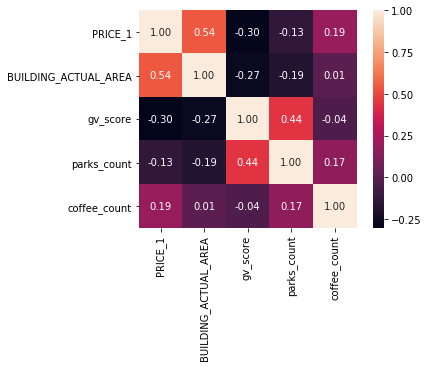

In [1095]:
corr(merged_df[['PRICE_1', 'BUILDING_ACTUAL_AREA', 'gv_score', 'parks_count', 'coffee_count']])

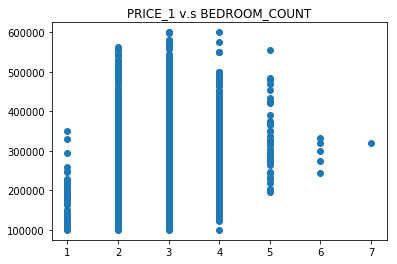

In [1096]:
scatter_vs_price(merged_df, 'BEDROOM_COUNT')

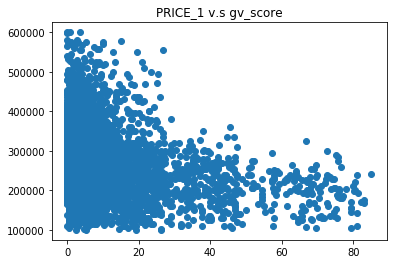

In [1097]:
scatter_vs_price(merged_df, 'gv_score')

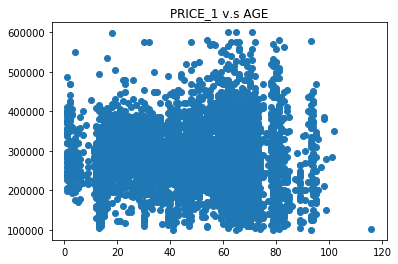

In [1098]:
scatter_vs_price(merged_df, 'AGE')

## Prepare Data For Learning

In [1099]:
merged_df.columns

Index(['X', 'Y', 'CITY', 'ZIP', 'CONDO_FLAG', 'BEDROOM_COUNT',
       'BATHROOM_COUNT', 'HALF_BATHROOM_COUNT', 'FLOOR_COUNT', 'UNIT_COUNT',
       'BUILDING_ACTUAL_AREA', 'BUILDING_HEATED_AREA', 'LOT_SIZE',
       'YEAR_BUILT', 'ASSESSMENT_YEAR_CUR', 'ASSESSED_VAL_CUR', 'PRICE_1',
       'DATEOFSALE_UTC', 'SQRD_FOOT_PRICE', 'AGE', 'OUTDOORS_AREA',
       'property_index', 'incident_count', 'injured_count', 'killed_count',
       'gv_score', 'grocery_count', 'restaurant_count', 'hospitals_count',
       'coffee_count', 'bars_count', 'gas_count', 'parks_count', 'edu_count'],
      dtype='object')

In [1100]:
include_cols = ['BEDROOM_COUNT', 'BATHROOM_COUNT', 'AGE',
                'BUILDING_ACTUAL_AREA', 'FLOOR_COUNT', 'X', 'Y',
                'parks_count', 'coffee_count', 'gv_score'
                ]


target = merged_df.PRICE_1 
data = merged_df[include_cols]
data.describe()

BEDROOM_COUNT  BATHROOM_COUNT          AGE  BUILDING_ACTUAL_AREA  \
count    6052.000000     6052.000000  6052.000000           6052.000000   
mean        2.914078        1.741904    48.179610           1555.032056   
std         0.662687        0.540364    22.345382            329.335868   
min         1.000000        1.000000     1.000000            544.000000   
25%         3.000000        1.000000    30.000000           1308.000000   
50%         3.000000        2.000000    53.500000           1578.000000   
75%         3.000000        2.000000    66.000000           1825.250000   
max         7.000000        5.000000   116.000000           2100.000000   

       FLOOR_COUNT            X            Y  parks_count  coffee_count  \
count  6052.000000  6052.000000  6052.000000  6052.000000   6052.000000   
mean      1.150364   -80.316029    25.755324     3.609055      0.865003   
std       0.357457     0.088315     0.150723     3.308194      1.166286   
min       1.000000   -80.536633    25.437963     0.000000      0.000000   
25%       1.000000   -80.390717    25.630499     2.000000      0.000000   
50%       1.000000   -80.317512    25.767786     3.000000      0.000000   
75%       1.000000   -80.236148    25.887833     4.000000      1.000000   
max       2.000000   -80.123061    25.974065    20.000000     12.000000   

          gv_score  
count  6052.000000  
mean      8.819795  
std      12.985122  
min       0.000000  
25%       1.400000  
50%       4.100000  
75%      10.400000  
max      85.100000

## Linear Regression Model

In [1101]:
print(data.shape)

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

d_df = pd.DataFrame(data,columns=include_cols)
d_df['Price'] = target.values


for col in include_cols:
    d_df = six_sigma_filter(d_df, col)

    
target = d_df.Price
d_df = d_df.drop(['Price'], axis=1)
print(d_df.shape)


(6052, 10)
Column:BEDROOM_COUNT, Mean:0.0, Sigma:1.0, 6 sigma_range: -3.0:3.0
Number of rows dropped: 49
Column:BATHROOM_COUNT, Mean:-0.015, Sigma:0.983, 6 sigma_range: -2.96:2.93
Number of rows dropped: 8
Column:AGE, Mean:-0.005, Sigma:1.001, 6 sigma_range: -3.01:3.0
Number of rows dropped: 1
Column:BUILDING_ACTUAL_AREA, Mean:-0.008, Sigma:0.999, 6 sigma_range: -3.0:2.99
Number of rows dropped: 5
Column:FLOOR_COUNT, Mean:0.004, Sigma:1.004, 6 sigma_range: -3.01:3.02
Number of rows dropped: 0
Column:X, Mean:-0.008, Sigma:1.001, 6 sigma_range: -3.01:2.99
Number of rows dropped: 0
Column:Y, Mean:-0.005, Sigma:1.002, 6 sigma_range: -3.01:3.0
Number of rows dropped: 0
Column:parks_count, Mean:-0.002, Sigma:1.0, 6 sigma_range: -3.0:3.0
Number of rows dropped: 132
Column:coffee_count, Mean:-0.015, Sigma:0.986, 6 sigma_range: -2.97:2.94
Number of rows dropped: 57
Column:gv_score, Mean:-0.035, Sigma:0.954, 6 sigma_range: -2.9:2.83
Number of rows dropped: 147
(5653, 10)


In [1102]:
X_train , X_test , y_train , y_test = train_test_split(d_df, target, test_size=0.20, random_state=2)
print(len(X_train), len(X_test))

4522 1131


In [1103]:
lr_model = LinearRegression()

In [1104]:
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1105]:
print(lr_model.score(X_train, y_train))
print(lr_model.score(X_test, y_test))

print("MAE: {}".format(mean_absolute_error(y_test, lr_model.predict(X_test))))

0.4225750600181095
0.3961106198007389
MAE: 48048.32090588979


## Gradient Boosting Regressor

In [1106]:
from sklearn import ensemble

clf = ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=4, min_samples_split=2,
          learning_rate=0.05, loss='ls')

In [1107]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## $R^2$ score

In [1108]:
print(clf.score(X_train, y_train))
print(clf.score(X_test,y_test))

0.7435715456512404
0.5942689982473834


In [1109]:
# weights of each feature.

zipped = zip(X_train.columns.values, clf.feature_importances_)
for f in sorted(zipped, key = lambda x: x[1], reverse=True):
    print(f)

('BUILDING_ACTUAL_AREA', 0.3955376495357877)
('Y', 0.2995759896210982)
('gv_score', 0.10878440014914599)
('X', 0.10140852125313174)
('AGE', 0.03686621641230395)
('FLOOR_COUNT', 0.034300567965471575)
('parks_count', 0.008594401299598504)
('coffee_count', 0.006159181917730108)
('BEDROOM_COUNT', 0.005194234572929372)
('BATHROOM_COUNT', 0.0035788372728031157)


## Mean Absolute Error

In [1110]:
y_pred = clf.predict(X_test)
mean_absolute_error(y_test, y_pred)

36780.0020898205

In [1111]:
err = pd.DataFrame(abs((y_pred - y_test).values))
err.describe()

0
count    1131.000000
mean    36780.002090
std     35324.836574
min         2.508400
25%     10743.724704
50%     26312.547987
75%     51084.652538
max    274282.748965

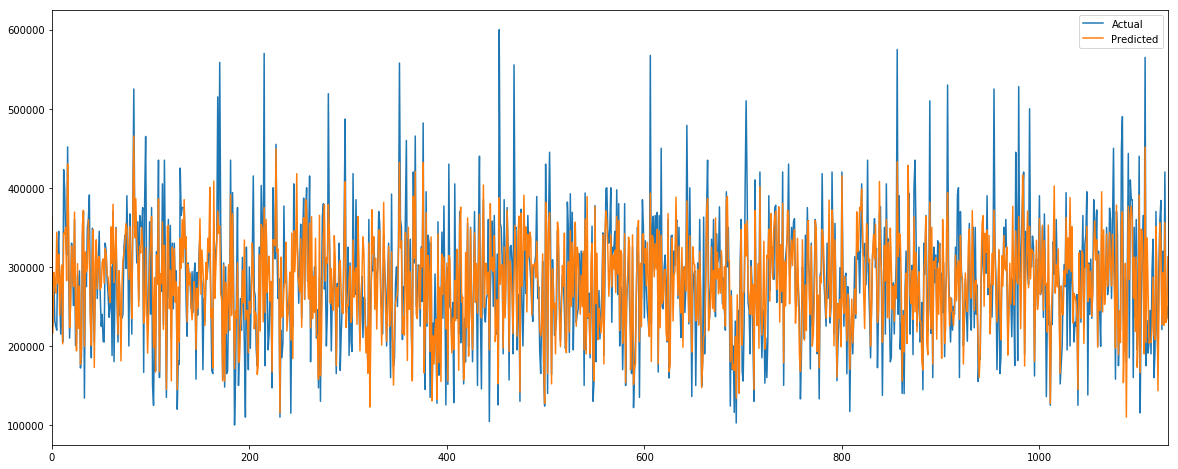

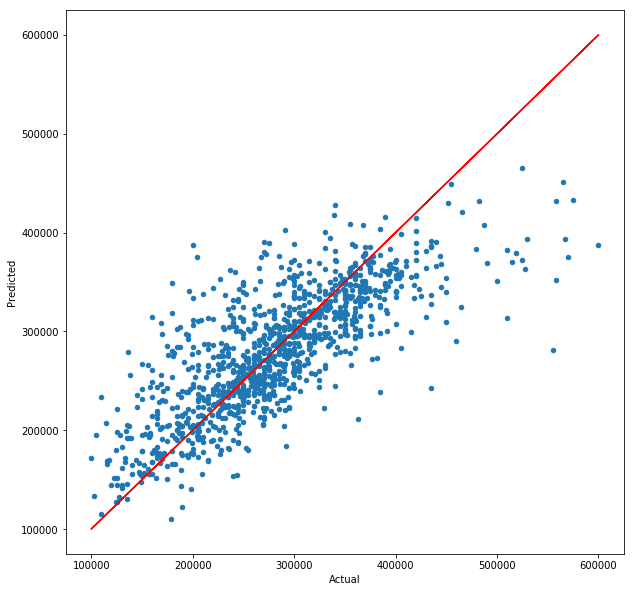

In [1112]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
results.plot(kind='line',figsize=(20,8))

results.plot.scatter('Actual', 'Predicted', figsize=(10,10))
plt.plot(y_test, y_test, '-', color='r')
plt.show()